# Least-Squares Reverse Time Migration through Devito and Automatic Differentiation

@Author: Francesco Picetti - picettifrancesco@gmail.com


In this tutorial, we put together torch's Automatic Differentiation abilities and the OccamyPy physical operators (well, actually Devito's) for RTM. Basically, we can write a standard pytorch optimization loop with the modeling provided by OccamyPy; the tricky part is to insert a linear operator (i.e., Born) in the AD graph.

To use this notebook, we need devito installed. On your occamypy-ready env, run

```pip install --user git+https://github.com/devitocodes/devito.git```

In [1]:
import torch
import occamypy as o
import born_devito as b

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'gray',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Setup

In [2]:
args = dict(
    filter_sigma=(1, 1),
    spacing=(10., 10.),  # meters
    shape=(101, 101),    # samples
    nbl=20,              # samples
    nreceivers=51,
    src_x=[500],         # meters
    src_depth=20.,       # meters
    rec_depth=30.,       # meters
    t0=0.,
    tn=2000.,            # Simulation lasts 2 second (in ms)
    f0=0.010,            # Source peak frequency is 10Hz (in kHz)
    space_order=5,
    kernel="OT2",
    src_type='Ricker',
)

In [3]:
def unpad(model, nbl: int = args["nbl"]):
    return model[nbl:-nbl, nbl:-nbl]

create hard model and migration model

In [4]:
model_true, model_smooth, water = b.create_models(args)
model = o.VectorNumpy(model_smooth.vp.data.__array__())
model.ax_info = [
    o.AxInfo(model_smooth.vp.shape[0], model_smooth.origin[0] - model_smooth.nbl * model_smooth.spacing[0],
             model_smooth.spacing[0], "x [m]"),
    o.AxInfo(model_smooth.vp.shape[1], model_smooth.origin[1] - model_smooth.nbl * model_smooth.spacing[1],
             model_smooth.spacing[1], "z [m]")]
model_extent = [0., 1000., 1000., 0.]

Define acquisition geometry

In [5]:
rec = b.build_rec_coordinates(model_true, args)
src = [b.build_src_coordinates(x, args["src_depth"]) for x in args["src_x"]]

### create the common shot gather (CSG) data

In [6]:
d = o.VectorTorch(b.propagate_shots(model=model_true, src_pos=src, rec_pos=rec, param=args))
assert d[:].requires_grad is False

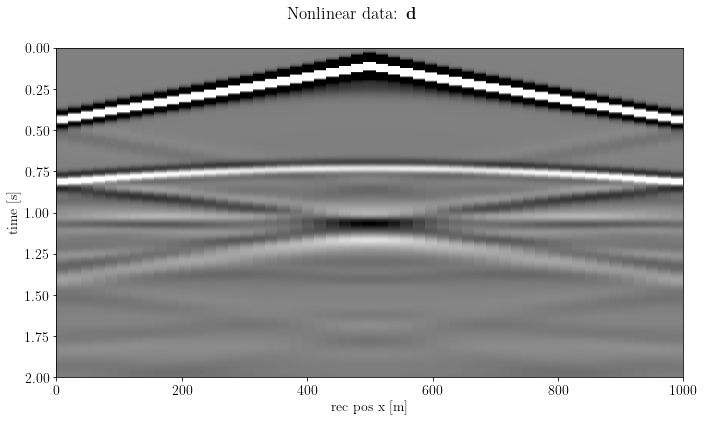

In [7]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(d.plot(), clim=o.plot.clim(d[:]),
           extent=[d.ax_info[1].o, d.ax_info[1].last, d.ax_info[0].last, d.ax_info[0].o])
axs.set_xlabel(d.ax_info[1].l)
axs.set_ylabel(d.ax_info[0].l)
fig.suptitle(r"Nonlinear data: $\mathbf{d}$")
plt.tight_layout()
plt.show()

## Instantiate the Born operator...

In [8]:
B = b.BornSingleSource(velocity=model_smooth, src_pos=src[0], rec_pos=rec, args=args)

### ... and cast it to an Autograd function

In [9]:
B_ = o.torch.AutogradFunction(B)

## Learning paradigm

instantiate the model as a "learnable" vector, i.e., a new kind of `VectorTorch` that encapsulate a tensor attached to the AD graph

In [10]:
m = o.torch.VectorAD(torch.zeros(model.shape), ax_info=model.ax_info)

m.setDevice(None)

assert m[:].requires_grad is True

instantiate the optimizer that will work on the model

In [11]:
opt = torch.optim.SGD([m.getNdArray()], lr=1)

define the objective function terms: the mean squared error...

In [12]:
mse = torch.nn.MSELoss().to(m.device)

and more complex terms (the TV, for example) that can be based on OccamyPy operators!

In [13]:
G = o.torch.AutogradFunction(o.FirstDerivative(model, axis=0))
l1 = torch.nn.L1Loss().to(m.device)
tv = lambda x: l1(G(x), torch.zeros_like(x))

## Optimization loop

In [14]:
epochs = 10

In [15]:
for epoch in range(epochs):
    
    # modeling
    d_ = B_(m)
    
    # note: things can be a lot complicated! Deep Priors, CNN-based denoisers, ecc ecc
    
    # objective function
    loss = mse(d_.float(), d[:]) + 0.1 * tv(m.getNdArray())
    
    # model update
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    # log
    print("Epoch %s, obj = %.2e" % (str(epoch).zfill(3), loss))

Epoch 000, obj = 1.44e+00
Epoch 001, obj = 1.02e+00
Epoch 002, obj = 8.32e-01
Epoch 003, obj = 7.27e-01
Epoch 004, obj = 6.63e-01
Epoch 005, obj = 6.20e-01
Epoch 006, obj = 5.89e-01
Epoch 007, obj = 5.66e-01
Epoch 008, obj = 5.47e-01
Epoch 009, obj = 5.32e-01


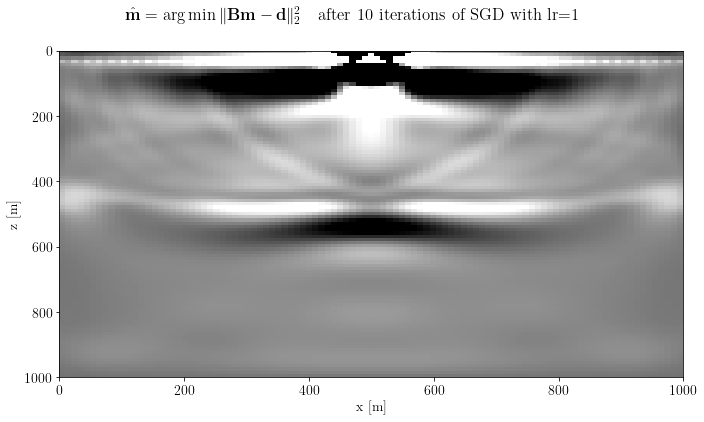

In [16]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(unpad(m.plot()).T, clim=o.plot.clim(m.plot()), extent=model_extent)
axs.set_xlabel(m.ax_info[0].l)
axs.set_ylabel(m.ax_info[1].l)
fig.suptitle(r"$\hat{\mathbf{m}} = \arg \min \Vert \mathbf{B}\mathbf{m} - \mathbf{d} \Vert_2^2 \quad$" + f"after {epochs} iterations of SGD with lr={opt.param_groups[0]['lr']}")
plt.tight_layout()
plt.show()

## Shot-wise Dask distribution: WIP

In principle, an `AutogradFunction` can be casted also for Dask-distributed operators.
However, distributing a shot to each workers (as done in the [previous tutorial](./2D%20LS-RTM%20with%20devito.ipynb)) will require the objective function to be computed on different workers, too.
   
Therefore, we need to merge the distribution paradigms of Dask and PyTorch. Any help will be appreciated!